---> things corrected

- inceptionV3 need 299x299 input and VGG16 needs 224X224. Thus instead of guess work that whether "target_size" of input image should be 224x224 or 299x299 or something else, simply do "vgg16_model.input_shape". Already done where images are getting encoded

- assuming that image features extracted by VGG/inception is always pf (2048, ) size is wrong........depending on input size you choose to generate encoding of and which layer of InceptionV3/VGG16 we choose, this feature dim will keep changing.......so best way is that at part where you are defining main arch, there use "feature_size" variable instead of "(2048, )". This variable is getting its value from output of extracted feature directly. Thus no guessing needed.

- choices like include_top=True/False and pre_trained_model.layers[-1]/pre_trained_model.layers[-2] can change the structure of feature extractor model, so be careful whike choosing these two parameters and for safety use "visualization function" to see if you are using the right layer of CNN to extract features from and refer to code which has already used these parameters with VGG/InceptionV3. Also by default, include_top = True

# Use GPU

**STEP 1) CONNECTING GOOGLE COLAB TO GOOGLE DRIVE**

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**STEP 2) IMPORTING LIBRARIES**

In [2]:
import pickle
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import string
import glob
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu
from time import time
from pathlib import Path
# Load the TensorBoard notebook extension
%load_ext tensorboard

**STEP 3) SETTING UP WORKING PLATFORM**

In [3]:
# Skip this code block if you have already cloned the github repo in your GDrive


# Change working directory to your Google Drive
os.chdir('/content/drive/MyDrive/')

# Cloning the repository in your Google Drive.
# If you are doing inference right after doing training then no need to clone as during training process, this GitHub repo is cloned.
!git clone https://github.com/malayjoshi13/Describer.git

Cloning into 'Describer'...
remote: Enumerating objects: 533, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 533 (delta 27), reused 39 (delta 9), pack-reused 443
Receiving objects: 100% (533/533), 28.69 MiB | 18.45 MiB/s, done.
Resolving deltas: 100% (291/291), done.


In [4]:
# Change working directory to your cloned repository
os.chdir('/content/drive/MyDrive/Describer/')

# Enter location of folder inside directory named "Describer" in your Google Drive, from where you will fetch trained model and needed files.
# Two options:
#     "temporary" (if evaluating on your own trained model) or
#     "default_model_checkpoint" (if evaluating on default pre-trained model)
chkp_location = "./temporary/"

Path(chkp_location).mkdir(parents=True, exist_ok=True)

In [ ]:
# import os

# os.chdir('/content/drive/MyDrive/_Projects_needed_files/Describer/')

# dir_name = "dataset/All_images"
# test = os.listdir(dir_name)

# for item in test:
#     if item.endswith(".npy"):
#         os.remove(os.path.join(dir_name, item))

### **4) PRE-PROCESSING CAPTIONS AND IMAGES**

**STEP 4.1) Encoding all images (training+testing)**

In [5]:
# fn to preprocess image input to ImageNet model
def preprocess_image(name, input_img_size):
  # image = load_img(name, target_size=(299, 299))
  image = load_img(name, target_size=input_img_size) # instead of guess work that whether "target_size" of input image should be 224x224 or 299x299 or something else, simply do "vgg16_model.input_shape"/"inceptionv3_model.input_shape"
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = preprocess_input(image) #by default fn made by keras to normalize image
  return image

# Initialising pre-trained InceptionV3
pre_trained_model = InceptionV3(weights="imagenet")
input_img_size = pre_trained_model.input_shape[1:3]

# Initializing feature extractor model which will use to get image encodings
feature_ext_encoder = Model(pre_trained_model.input, pre_trained_model.layers[-2].output)

96112376/96112376 [==============================] - 1s 0us/step


In [6]:
# dont run, already encoded and saved




# Getting paths of all images present in "Flicker8k_Dataset folder"
images = 'dataset/All_images/'
img = glob.glob(images+'*.jpg')
print("total images to processed "+str(len(img)))

count = 0

# Pre-processing images of "All_images" folder to make them suitable for
# being encoded by "encoder" model
image_enc = dict()
for name in img:
  count+=1
  print("images processed "+str(count))

  image  = preprocess_image(name, input_img_size)

  # Getting feature of image
  feature = feature_ext_encoder.predict(image)

  # Reshaping extracted image feature, fpr ex: in InceptionV3 (1,2048) into size (2048, )
  feature = np.reshape(feature, feature.shape[1])
  image_feature_shape = feature.shape

  # Then we save encodings of each of the images along with corresponding name in a dictionary named "image_enc"
  name = name.split('/')[-1]
  image_id = name.split('.')[0]
  image_enc[image_id] = feature

# Then we save this dictionary
with open(chkp_location+"all_images_encodings.pkl", "wb") as encoded_pickle:
    pickle.dump(image_enc, encoded_pickle)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 26ms/step
images processed 5595
1/1 [==============================] - 0s 31ms/step
images processed 5596
1/1 [==============================] - 0s 29ms/step
images processed 5597
1/1 [==============================] - 0s 26ms/step
images processed 5598
1/1 [==============================] - 0s 25ms/step
images processed 5599
1/1 [==============================] - 0s 24ms/step
images processed 5600
1/1 [==============================] - 0s 31ms/step
images processed 5601
1/1 [==============================] - 0s 28ms/step
images processed 5602
1/1 [==============================] - 0s 32ms/step
images processed 5603
1/1 [==============================] - 0s 26ms/step
images processed 5604
1/1 [==============================] - 0s 31ms/step
images processed 5605
1/1 [==============================] - 0s 34ms/step
images processed 5606
1/1 [==============================] - 0s 24ms/step
images pr

**STEP 4.2) Cleaning up all captions (training+validation+testing)**

In [7]:
# dont run, already run once


# Reading captions in "captions.txt" file and storing them into variable
with open('dataset/captions.txt', 'r') as file:
 content = file.read()

captions = dict()
for line in content.split('\n'):
    # "content" after getting splitted on basis of "\n" will be of kind:
    # 302241178_a582c1b953.jpg#0	A dog in water carrying.......

    bits = line.split()
    # Each "line" from splitted "content" will further get split according to white
    # space to be of form:
    # ['302241178_a582c1b953.jpg#0', 'A', 'dog', 'in', 'water', 'carrying',.....]

    # to check if "bits" is not an empty list
    if bits:
      # to get name of the image
      idd = bits[0].split('.')[0]
      # to get caption
      cap = bits[1:]
      cap = ' '.join(cap)
      # then if name of image is not in present in dictionary "captions" as a "key", then we initiate it otherwise if already present, then we will simply add the caption
      # (related to that image) as a "value" with image name (acting as a "key" in dictionary "captions")
      if idd not in captions:
          captions[idd] = list()
      captions[idd].append(cap)
# Finally this dictionary "captions" will look like:
# {'1000268201_693b08cb0e': ['A child in a........way .', 'A girl going......building .',......], '1001773457_577c3a7d70': ['A black dog....fighting', 'A black dog......other on the road .',......}

table = str.maketrans('', '', string.punctuation)
for key, caption_list in captions.items():
    for i in range(len(caption_list)):
        # now we pick up every caption from every "caption_list"
        caption = caption_list[i]
        # and then split that particular caption and store each word of it in a list "caption_splits"
        caption_splits = caption.split()
        # then lower case every word in every caption of "caption_list"
        lowered_caption = [word.lower() for word in caption_splits]
        # then removed all punctuations in every caption of "caption_list
        no_punctuation_caption = [word.translate(table) for word in lowered_caption]
        # then removed all single letter words like a, s of malay's, etc in every caption of "caption_list
        no_single_letter_caption = [word for word in no_punctuation_caption if len(word)>1]
        # then removed all number in every caption of "caption_list
        no_number_caption = [word for word in no_single_letter_caption if word.isalpha()]
        # finally assigning the caption who has crossed all stages of processing to "processed_caption" variable
        processed_caption = no_number_caption
        # then we finally join each processed caption as a "value" to a particular "image path" "key"
        caption_list[i] =  ' '.join(processed_caption)
# After cleaning captions in dictionary "captions" will look like:
# {'1000268201_693b08cb0e': ['child in pink dress....entry way', 'girl going....building', 'little....wooden playhouse',........], '1001773457_577c3a7d70': ['black dog and spotted dog are fighting', 'black dog and tricolored dog.......}

modified_captions = list()
for key, caption_list in captions.items():
    for each_cap in caption_list:
        #breaking captions and adding 'startseq' and 'endseq' on both ends
        each_cap = 'startseq ' + each_cap + ' endseq'
        #adding 'key' to this new caption and adding it to 'modified_captions' dataset
        modified_captions.append(key + ' ' + each_cap)

# list "modified_captions" will look like:
# .
# .
# 979201222_75b6456d34 startseq two girls are walking arm in arm past an amusement arcade endseq
# 979201222_75b6456d34 startseq two girls are walking away from the camera under walkway endseq
# 979201222_75b6456d34 startseq two girls in shorts walk towards casino signs endseq
# 979201222_75b6456d34 startseq two teenage girls walking down mall breezeway endseq

with open(chkp_location+'processed_captions.txt', 'w') as f:
    for caption in modified_captions:
      f.write(caption)
      f.write('\n')

### **5) Seperating training images and captions**

**STEP 5.1) Reading names of training images present in "TrainImagesNames.txt"**

In [8]:
# Reading names of training images present in "TrainImagesNames.txt" file and storing them in "training_images_name" variable
with open('dataset/TrainImagesName.txt', 'r') as file:
 text_content = file.read()

training_images_name = list()
for line in text_content.split('\n'):
    if len(line) < 1:
        continue
    name = line.split('.')[0]
    training_images_name.append(name)

**STEP 5.2) Seperating encodings of training images from total images encodings**









In [9]:
# First we read all image encodings from "all_images_encodings.pkl" file and store it into "content" variable
image_content = pickle.load(open(chkp_location+'all_images_encodings.pkl', 'rb'))

# Then one by one we pick names of every training images from list "training_images_name" (from step 3.1) using "for k in training_images_name".
# Then we save pairs of "training_images_names" and their correponding "image encodings" in dictionary "training_images_features" by using "k: content[k]";
# here k->name of training image and content[k]->encoding of that training image
training_images_encodings = {k: image_content[k] for k in training_images_name}

**STEP 5.3) Seperating training captions from total captions (corresponding to total images)**

In [10]:
# Then we check that from dictionary "modified_captions" which we made in (step 2.2),
# which all pairs of imagename and corrrespponding caption matches to names of training images name present in "FinalTrainImagesNames.txt" file
# This is done to validate if caption for a image-name is present but corresponding image is not present in images folder.

training_captions = dict()

with open(chkp_location+'processed_captions.txt', 'r') as f:
    for line in f.readlines():
      bits = line.split()
      idd, caps_token = bits[0], bits[1:]
      if idd in training_images_name:
          if idd not in training_captions:
              training_captions[idd] = list()
          caps = ' '.join(caps_token)
          training_captions[idd].append(caps)
# This "training_captions" dictionary having training_images_name and their captions pairs looks like:
# {'1000268201_693b08cb0e': ['startseq child in pink dress....entry way endseq', 'startseq girl....building endseq', 'startseq little girl....endseq',.....], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',...}

**STEP 5.4) For training captions, creating vocabulary of most occuring words. Also creating two dictionaries to map words to an index and vice versa**

In [11]:
# dont run



# We will first store all captions correponding to each and every image name
# into a list "values_of_training_captions1".
values_of_training_captions = list()
for key, val in training_captions.items():
    for cap in val:
        values_of_training_captions.append(cap)

# Then to count max possible length of any training caption, we will pick up each caption,
# count number of words in that picked caption and outputs the maximum of all countings.
# Using this parameter as a reference we will be later on doing padding of training captions.
max_length = max(len(values.split()) for values in values_of_training_captions)
print(max_length)

# Now we find words which occur very frequently (more than 10 times) and save those
# words into list "most_occuring".
threshold = 10
counts = {}
for each_sentence in values_of_training_captions:
    for each_word in each_sentence.split(' '):
        counts[each_word] = counts.get(each_word, 0) + 1
most_occuring = [each_word for each_word in counts if counts[each_word] >= threshold]

# Now we label map all words present in list "most_occuring" to an integer value, i.e we refer words
# with some numerical value (and stored this is in dictionary "word_to_index") starting from "1" like.
# And we also create another reversal dictionary "index_to_word" which will
# help to reverse these referenced numbers to their actual alphabhetic
# "words" of training captions.
word_to_index = {}
index_to_word = {}
index = 1
for each_word in most_occuring:
    index_to_word[index] = each_word
    word_to_index[each_word] = index
    index += 1
# "word_to_index" dictionary looks like: {'startseq': 1, 'child': 2, 'in': 3, 'pink': 4, 'dress': 5, 'is': 6,...}
# "index_to_word" dictionary looks like: {1: 'startseq', 2: 'child', 3: 'in', 4: 'pink', 5: 'dress', 6: 'is'...}

# as indexing is starting from "1" and not "0", thus final vocab size increase by 1
vocab_size = len(most_occuring)+1
print(vocab_size)

with open(chkp_location+"word_to_index.pkl", "wb") as encoded_pickle:
    pickle.dump(word_to_index, encoded_pickle)
with open(chkp_location+"index_to_word.pkl", "wb") as encoded_pickles:
    pickle.dump(index_to_word, encoded_pickles)

34
1652


**STEP 5.5) Using GloVe to generate embeddings for each word in the vocabulary. This vocabulary has most occuring words present in training captions. Using Glove we will map all the words in our 34 words long caption to a 200-dimension vector.**

In [12]:
# dont run



# We read content of "glove.6B.200d.txt" file
file = open('dataset/glove.6B.200d.txt', encoding="utf-8")

# Now what we do is that we pick each line from this variable "content" such that
# each line has one unique word + its coordinates in a 200D plane.
# Then from each line we seperate the word from its coordinates and store them as
# key-value pair in "embedding_of_each_key_word" dictionary.
# Here "key_word" which is word->key of dictionary and "embedding_vector" which is
# coordinates in 200D plane->value of dictionary
embedding_of_each_key_word = {}
for line in file:
    splits = line.split()
    key_word = splits[0]
    embedding_vector = np.asarray(splits[1:], dtype='float32')
    embedding_of_each_key_word[key_word] = embedding_vector

file.close()

# Next task is that out of all words-Glove embedding pairs stored in
# "embedding_of_each_key_word" dictionary, we pick Glove embeddings of only
# those words which are present in training captions.
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in word_to_index.items():
    embedding_vector = embedding_of_each_key_word.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

with open(chkp_location+"all_captions_GLOVE_embedding.pkl", "wb") as encoded_pickle:
    pickle.dump(embedding_matrix, encoded_pickle)

### **6) Seperating validation images and captions**

**STEP 6.1) Reading names of validation images present in "DevImagesNames.txt"**

In [13]:
# Reading names of validation images present in "DevImagesNames.txt" file and storing them in "val_images_name" variable
with open('dataset/DevImagesName.txt', 'r') as file:
 text_content = file.read()

val_images_name = list()
for line in text_content.split('\n'):
    if len(line) < 1:
        continue
    name = line.split('.')[0]
    val_images_name.append(name)

**STEP 6.2) Seperating encodings of validation images from total images encodings**


In [14]:
# First we read all image encodings from "all_images_encodings.pkl" file and store it into "content" variable
image_content = pickle.load(open(chkp_location+'all_images_encodings.pkl', 'rb'))

# Then one by one we pick names of every validation images from list "val_images_name" (from step 4.1) using "for k in training_images_name".
# Then we save pairs of "val_images_name" and their correponding "image encodings" in dictionary "val_images_encodings" by using "k: content[k]";
# here k->name of validation image and content[k]->encoding of that validation image
val_images_encodings = {k: image_content[k] for k in val_images_name}

**STEP 6.3) Seperating validation captions from captions corresponding to total images**

In [15]:
# Then we check that from dictionary "modified_captions" which we made in (step 2.2),
# which all imagename-caption pair matches to names of val images name present in "DevImagesNames.txt" file
# (this is to see if caption for a image-name is present but that image is not present in images folder)
val_captions = dict()

with open(chkp_location+'processed_captions.txt', 'r') as f:
    for line in f.readlines():
      bits = line.split()
      idd, caps_token = bits[0], bits[1:]
      if idd in val_images_name:
          if idd not in val_captions:
              val_captions[idd] = list()
          caps = ' '.join(caps_token)
          val_captions[idd].append(caps)
# This "val_captions" dictionary having val_images_name and their captions pairs looks like:
# {'1000268201_693b08cb0e': ['startseq child in pink dress....entry way endseq', 'startseq girl....building endseq', 'startseq little girl....endseq',.....], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',...}

### **7) Scripting function called "data_generator"**

Since our dataset has 6000 images and 40000 captions we will create a function that can train the data in batches.



In [16]:
def data_generator(captions, images_encodings, word_to_index, max_length, num_of_training_img_per_batch):
  images_passed_in_single_batch=0
  total_images_passed = 0
  names_images_passed_in_single_batch = list()
  X1, X2, y = list(), list(), list()

# flow will be like pick one image & its 5 captions. Store them into a batch and check if size of batch has become equal to "num_of_training_img_per_batch". If becomes equal, push that whole batch to be used for training.
# also this is an infinite flow because we used "while" loop, i.e. even if "data_generator" push whole data once, then also it keeps on pushing whole data again for training and validation purposes.
# to limit this flow so that for each epoch only 6000 training images and 1000 val images get passed, we use "steps_per_epoch" and "validation_steps" (to see that data_generator for infinite time can generate and push data, just increase
# "steps_per_epoch" from 200 to 250 and "validation_steps" from 20 to 30. You will see that again same data is getting pushed into model)

  while True:
      # Lets suppose dictionary "captions" looks like:- {'1000268201_693b08cb0e' (name of some image without .jpg) : ['startseq child in pink dress....entry way endseq', 'startseq girl....building endseq', 'startseq little girl....endseq',.....], '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',...}
      for key, cap_list in captions.items():
      # So, for first itertation "key"= 1000268201_693b08cb0e and "cap_list"= ['startseq child in pink dress....entry way endseq', 'startseq girl....building endseq', 'startseq little girl....endseq',.....]
          images_passed_in_single_batch+=1
          # Now using "key"="1000268201_693b08cb0e", we will also extract image-encoding corresponding to imagename "1000268201_693b08cb0e" from "images_encodings" dictionary
          encoded_image = images_encodings[key]
          names_images_passed_in_single_batch.append(key)

          # For current iteration, "cap_list"= ['startseq child in pink dress....entry way endseq', 'startseq girl....building endseq', 'startseq little girl....endseq',.....]
          # Now out of "cap_list", in every iteration, we will one by one pick-up caption "cap" out of the 5 captions present in "cap_list"
          for cap in cap_list:
          # Now for current case "cap"= 'startseq child in pink dress....entry way endseq'
              # Now we split line "startseq child in pink dress....entry way endseq" into a list called "word"=["startseq", "child", "in", "pink"...., "way", "endseq"],
              # and then from "word_to_index" dictionary we extract the "numerical indexing" corresponding to each word stored in "word" named variable.
              # This will make "encoded_caption" to look like:- [22, 14, 3, 18,...] i.e. numerical indexings corresponding to words:- "startseq", "child", "in", "pink", etc.
              encoded_caption = [word_to_index[word] for word in cap.split(' ') if word in word_to_index]

              for i in range(1, len(encoded_caption)):
                  # This is quite interesting so understand it carefully.
                  # See for first iteration i=1, so input_encoded_partial_caption=encoded_caption[:1]=[22] and output_encoded_partial_caption=encoded_caption[1]=[14]
                  # This means we are giving input of "startseq" and we have to predict output of "child".
                  # Similarly for second iteration, input_encoded_partial_caption (input)=["startseq", "child"]=[22, 14] and output_encoded_partial_caption (output to be predicted)=["in"]=[3]
                  # Similarly for third iteration, input_encoded_partial_caption (input)=["startseq", "child", "in"]=[22, 14, 3] and output_encoded_partial_caption (output to be predicted)=["pink"]=[18]
                  input_encoded_partial_caption, output_encoded_partial_caption = encoded_caption[:i], encoded_caption[i]

                  # Role of "pad_sequences" in first iteration is to make:- input_encoded_partial_caption=[22,0,0,0.....upto max_length (which is 34 here)]
                  # Similarly for second iteration input_encoded_partial_caption=[22,14,0,0,0.....upto max_length]
                  # Similarly for third iteration input_encoded_partial_caption=[22,14,3,0,0.....upto max_length]
                  # In short, "pad_sequences" will make "input_encoded_partial_caption" of every iteration of equal length by adding 0s, i.e. equal to "max_length=34"
                  input_encoded_partial_caption = pad_sequences([input_encoded_partial_caption], maxlen=max_length)[0]

                  # Role of "to_categorical" in first iteration is to make output_encoded_partial_caption=[0,0,.....,1(at 14th place corresponding to "how"),0,0.....0(1798th place corresponding to last word in "most_occuring_words")]
                  # Role of "to_categorical" in second iteration is to make output_encoded_partial_caption=[0,0,1(at 3th place corresponding to "are"),0,0.....0(1798th place corresponding to last word in "most_occuring_words")]
                  # Role of "to_categorical" in first iteration is to make output_encoded_partial_caption=[0,0,..........., 1(at 18th place corresponding to "you"),0,0.....0(1798th place corresponding to last word in "most_occuring_words")]
                  output_encoded_partial_caption = to_categorical([output_encoded_partial_caption], num_classes=vocab_size)[0]

                  # And then we are just appending all this stuff into these three containers:X1, X2, y
                  # After this will go back to "for cap in cap_list" and do same for rest all "cap" also.
                  # Once appending process for all "cap" present in a particular "cap_list" is done, will go down to....
                  X1.append(encoded_image)
                  X2.append(input_encoded_partial_caption)
                  y.append(output_encoded_partial_caption)


          # ....here and see if condition of "images_passed_in_single_batch==num_of_training_img_per_batch" is been satisfied or not?
          # It will not be satisfied till it will do whole process for all captions corresponding to 35 (=num_of_training_img_per_batch) number of training images.
          if images_passed_in_single_batch==num_of_training_img_per_batch:
              # Once satisfied, it will push the data collected till now (by processing all captions of 3 training images) for training model over them
              yield ([np.array(X1), np.array(X2)], np.array(y))


              # And once pushed, everything will start freshly
              X1, X2, y = list(), list(), list()
              images_passed_in_single_batch=0
              names_images_passed_in_single_batch = list()

### **8) Creating structure of training model**



In [17]:
max_length=34
vocab_size=1652
embedding_dim=200
image_feature_shape=(2048,)

In [18]:
embedding_matrix = pickle.load(open(chkp_location+"all_captions_GLOVE_embedding.pkl", 'rb'))

# image-encoding pipeline
inputs1 = Input(shape=image_feature_shape)
layer1 = Dropout(0.5)(inputs1)
layer2 = Dense(256, activation='relu')(layer1)

# caption-pipeline
inputs2 = Input(shape=(max_length,))
layerA = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False, mask_zero=True)(inputs2)
layerB = Dropout(0.5)(layerA)
layerC = LSTM(256)(layerB)

# decoder (feed forward) model
merging_point = add([layer2, layerC])
activator = Dense(256, activation='relu')(merging_point)
outputs = Dense(vocab_size, activation='softmax')(activator)

training_model = Model(inputs=[inputs1, inputs2], outputs=outputs)

print(training_model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 34)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 34, 200)              330400    ['input_3[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 2048)                 0         ['input_2[0][0]']             
                                                                                            

In [19]:
# Configuring the model for training it under check of some parameters
training_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### **9) Starting the training process**



In [20]:
# So model will see the whole training data for 30 times (as epoch=30).

# In first full cycle (aka in every epoch), model will see all 6000 training images one-by-one in total 0f 200 steps_per_epoch (as steps_per_epoch = len(training_imagename_captions)//train_batch_size = 6000/30 = 200)
# After every epoch (i.e. after covering all 200 steps of every epoch) model will update its weights by doing backpropagation.

# Refer: https://keras.io/api/models/model_training_apis/

filepath = chkp_location+'weights/model-epoch{epoch:03d}-train_loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint=ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_accuracy', patience=7)

training_model.optimizer.lr = 0.0001
train_batch_size = 32
val_batch_size = 100
epochs = 10
steps_per_epoch = len(training_captions)//train_batch_size
validation_steps = len(val_captions)//val_batch_size
word_to_index = pickle.load(open(chkp_location+"word_to_index.pkl", 'rb'))
index_to_word = pickle.load(open(chkp_location+"index_to_word.pkl", 'rb'))

train_generator = data_generator(training_captions, training_images_encodings, word_to_index, max_length, train_batch_size)
val_generator = data_generator(val_captions, val_images_encodings, word_to_index, max_length, val_batch_size)
h = training_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data = val_generator, validation_steps = validation_steps, verbose=1, callbacks=[checkpoint, es]) # also note that validation data will be touched only afer one epoch ends, not during steps_per_epoch.

# another way to write above thing is:-
# for i in range(epochs):
    # train_generator = data_generator(training_captions, training_images_encodings, word_to_index, max_length, train_batch_size)
    # val_generator = data_generator(val_captions, val_images_encodings, word_to_index, max_length, val_batch_size) # batch size = len(val_captions) as I want at end of each epoch, validation must happen on full validation data and not on 35-35 validation data
    # h = training_model.fit(train_generator, epochs=1, steps_per_epoch=steps_per_epoch, validation_data = val_generator, validation_steps = validation_steps, verbose=1, callbacks=[tensorboard, checkpoint, es]) # also note that validation data will be touched only afer one epoch ends, not during steps_per_epoch.

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 5.7358 - accuracy: 0.1115
Epoch 1: val_loss improved from inf to 5.20338, saving model to ./temporary/weights/model-epoch001-train_loss5.736-val_loss5.203.h5
187/187 [==============================] - 50s 218ms/step - loss: 5.7358 - accuracy: 0.1115 - val_loss: 5.2034 - val_accuracy: 0.1506
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 5.0810 - accuracy: 0.1593
Epoch 2: val_loss improved from 5.20338 to 4.87139, saving model to ./temporary/weights/model-epoch002-train_loss5.081-val_loss4.871.h5
187/187 [==============================] - 38s 204ms/step - loss: 5.0810 - accuracy: 0.1593 - val_loss: 4.8714 - val_accuracy: 0.1771
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 4.7743 - accuracy: 0.1865
Epoch 3: val_loss improved from 4.87139 to 4.59315, saving model to ./temporary/weights/model-epoch003-train_loss4.774-val_loss4.593.h5
187/187 [==============================]

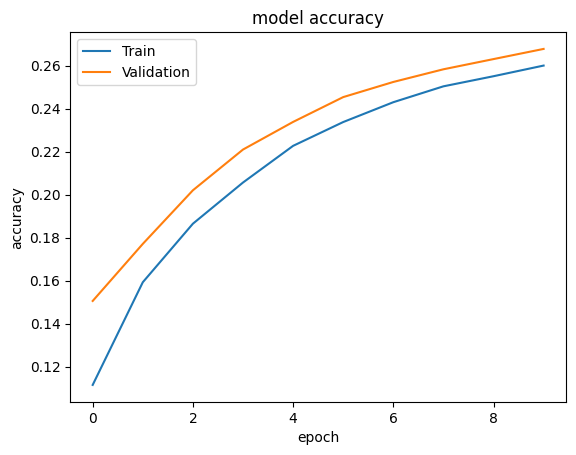

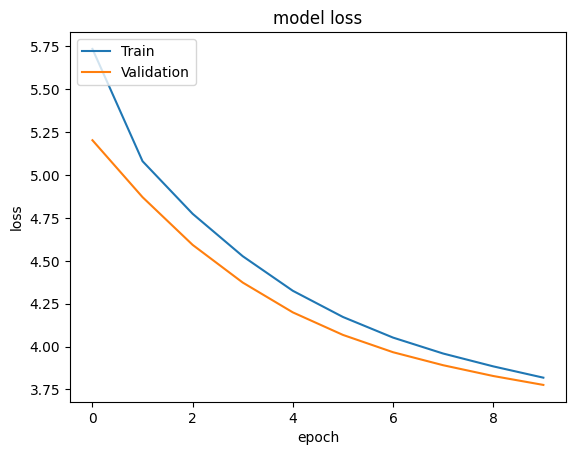

In [21]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
filepath = chkp_location+'weights/model-epoch{epoch:03d}-train_loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint=ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_accuracy', patience=7)

training_model.optimizer.lr = 0.0001
train_batch_size = 32
val_batch_size = 100
epochs = 10
steps_per_epoch = len(training_captions)//train_batch_size
validation_steps = len(val_captions)//val_batch_size
word_to_index = pickle.load(open(location+sub_location+"word_to_index.pkl", 'rb'))
index_to_word = pickle.load(open(location+sub_location+"index_to_word.pkl", 'rb'))

train_generator = data_generator(training_captions, training_images_encodings, word_to_index, max_length, train_batch_size)
val_generator = data_generator(val_captions, val_images_encodings, word_to_index, max_length, val_batch_size)
h = training_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data = val_generator, validation_steps = validation_steps, verbose=1, callbacks=[checkpoint, es]) # also note that validation data will be touched only afer one epoch ends, not during steps_per_epoch.


Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 3.7736 - accuracy: 0.2634
Epoch 1: val_loss improved from inf to 3.74078, saving model to /content/drive/MyDrive/_Projects_needed_files/Describer/temporary/weights/model-epoch001-train_loss3.774-val_loss3.741.h5
187/187 [==============================] - 36s 191ms/step - loss: 3.7736 - accuracy: 0.2634 - val_loss: 3.7408 - val_accuracy: 0.2706
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 3.7232 - accuracy: 0.2669
Epoch 2: val_loss improved from 3.74078 to 3.69944, saving model to /content/drive/MyDrive/_Projects_needed_files/Describer/temporary/weights/model-epoch002-train_loss3.723-val_loss3.699.h5
187/187 [==============================] - 37s 198ms/step - loss: 3.7232 - accuracy: 0.2669 - val_loss: 3.6994 - val_accuracy: 0.2741
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 3.6780 - accuracy: 0.2712
Epoch 3: val_loss improved from 3.69944 to 3.66450, saving model to 

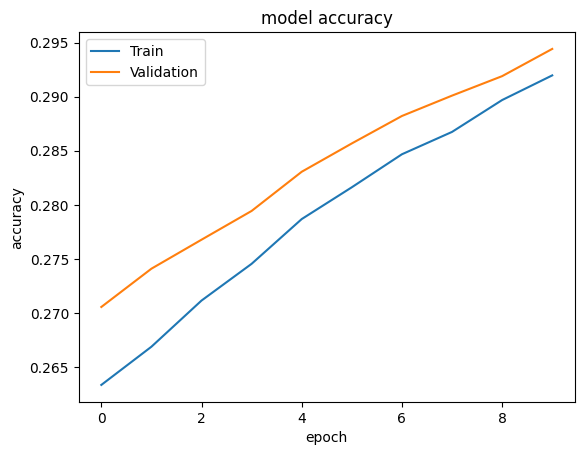

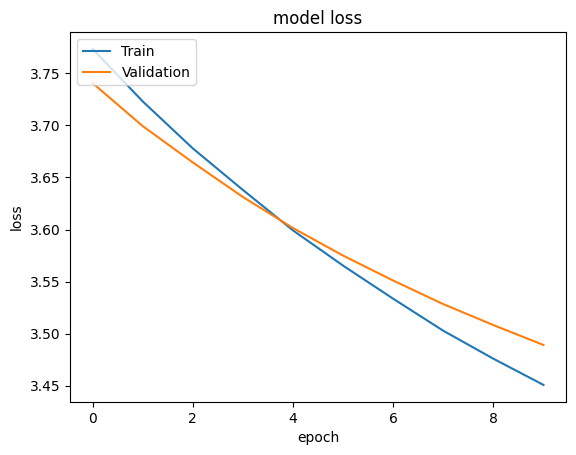

In [ ]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
filepath = chkp_location+'weights/model-epoch{epoch:03d}-train_loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint=ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_accuracy', patience=7)

training_model.optimizer.lr = 0.0001
train_batch_size = 128
val_batch_size = 100
epochs = 10
steps_per_epoch = len(training_captions)//train_batch_size
validation_steps = len(val_captions)//val_batch_size
word_to_index = pickle.load(open(location+sub_location+"word_to_index.pkl", 'rb'))
index_to_word = pickle.load(open(location+sub_location+"index_to_word.pkl", 'rb'))

train_generator = data_generator(training_captions, training_images_encodings, word_to_index, max_length, train_batch_size)
val_generator = data_generator(val_captions, val_images_encodings, word_to_index, max_length, val_batch_size)
h = training_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data = val_generator, validation_steps = validation_steps, verbose=1, callbacks=[checkpoint, es]) # also note that validation data will be touched only afer one epoch ends, not during steps_per_epoch.


Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 3.4203 - accuracy: 0.2951
Epoch 1: val_loss improved from inf to 3.47748, saving model to /content/drive/MyDrive/_Projects_needed_files/Describer/temporary/weights/model-epoch001-train_loss3.420-val_loss3.477.h5
46/46 [==============================] - 22s 480ms/step - loss: 3.4203 - accuracy: 0.2951 - val_loss: 3.4775 - val_accuracy: 0.2952
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 3.4093 - accuracy: 0.2963
Epoch 2: val_loss improved from 3.47748 to 3.47329, saving model to /content/drive/MyDrive/_Projects_needed_files/Describer/temporary/weights/model-epoch002-train_loss3.409-val_loss3.473.h5
46/46 [==============================] - 23s 499ms/step - loss: 3.4093 - accuracy: 0.2963 - val_loss: 3.4733 - val_accuracy: 0.2958
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 3.4022 - accuracy: 0.2965
Epoch 3: val_loss improved from 3.47329 to 3.46961, saving model to /content/d

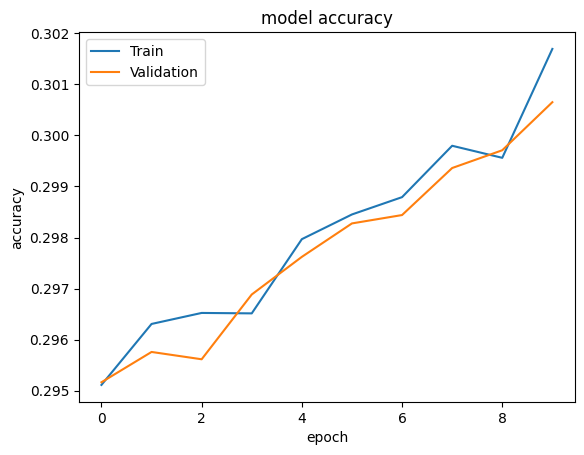

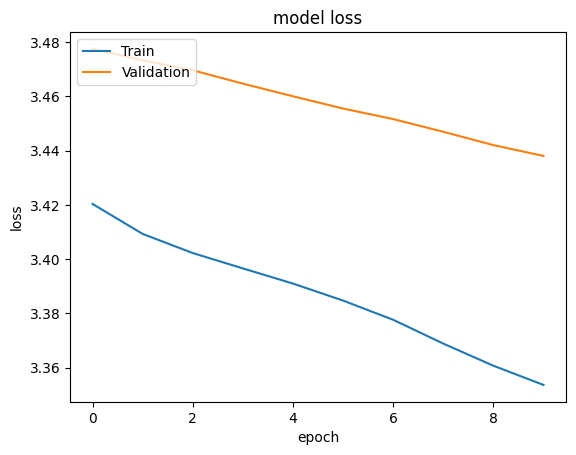

In [ ]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
filepath = chkp_location+'weights/model-epoch{epoch:03d}-train_loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint=ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')
es = EarlyStopping(monitor='val_accuracy', patience=7)

training_model.optimizer.lr = 0.0001
train_batch_size = 128
val_batch_size = 100
epochs = 10
steps_per_epoch = len(training_captions)//train_batch_size
validation_steps = len(val_captions)//val_batch_size
word_to_index = pickle.load(open(location+sub_location+"word_to_index.pkl", 'rb'))
index_to_word = pickle.load(open(location+sub_location+"index_to_word.pkl", 'rb'))

train_generator = data_generator(training_captions, training_images_encodings, word_to_index, max_length, train_batch_size)
val_generator = data_generator(val_captions, val_images_encodings, word_to_index, max_length, val_batch_size)
h = training_model.fit(train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch, validation_data = val_generator, validation_steps = validation_steps, verbose=1, callbacks=[checkpoint, es]) # also note that validation data will be touched only afer one epoch ends, not during steps_per_epoch.


Epoch 1/10
46/46 [==============================] - ETA: 0s - loss: 3.3515 - accuracy: 0.3025
Epoch 1: val_loss improved from inf to 3.43345, saving model to /content/drive/MyDrive/_Projects_needed_files/Describer/temporary/weights/model-epoch001-train_loss3.352-val_loss3.433.h5
46/46 [==============================] - 22s 484ms/step - loss: 3.3515 - accuracy: 0.3025 - val_loss: 3.4335 - val_accuracy: 0.2995
Epoch 2/10
46/46 [==============================] - ETA: 0s - loss: 3.3447 - accuracy: 0.3027
Epoch 2: val_loss improved from 3.43345 to 3.42976, saving model to /content/drive/MyDrive/_Projects_needed_files/Describer/temporary/weights/model-epoch002-train_loss3.345-val_loss3.430.h5
46/46 [==============================] - 23s 498ms/step - loss: 3.3447 - accuracy: 0.3027 - val_loss: 3.4298 - val_accuracy: 0.2996
Epoch 3/10
46/46 [==============================] - ETA: 0s - loss: 3.3381 - accuracy: 0.3029
Epoch 3: val_loss improved from 3.42976 to 3.42518, saving model to /content/d

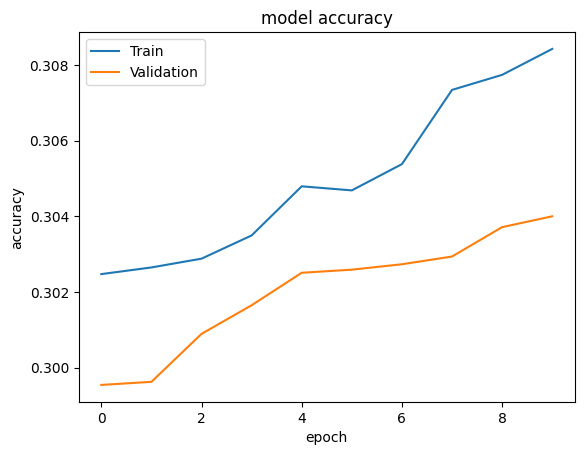

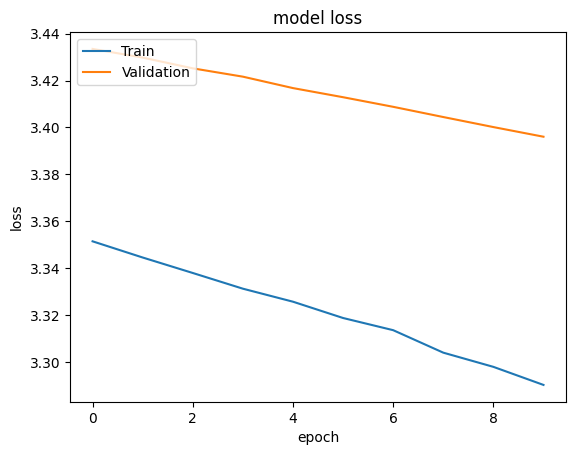

In [ ]:
# summarize history for accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()